In [1]:
import torch
import pandas as pd
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import warnings
import pickle
import numpy as np
import random
warnings.filterwarnings("ignore")

from models import ConvVAE, train_LSTM, LSTM, DNNVAE, eval_LSTM, AttentionLSTM, getModels
from dataloader import getVAE_DataLoader, getLSTM_Dataloader, LSTMData, getUnscaledData

VAE, _, _ = getModels('8221203', None, None)

with open('data/R2_STD_IVS_DFW_SORTED.pkl', 'rb') as file:
    standard_ivs = pickle.load(file)

exogenous = pd.read_csv('data/Exogenous_Variables.csv')

LATENT_DIM = 20
HIDDEN_SIZE=256
NUM_LAYERS=8
LEARNING_RATE=0.001
NUM_EPOCHS=80
BATCH_SIZE=8
FULL_IVS=True
ATTENTION=True

Attention: False | FULL_IVS: True | LATENT_DIM: 20
Epoch: 0 | Loss: 0.058 | Time Elapsed: 0.00 min
Epoch: 0 | Loss: 0.008 | Time Elapsed: 0.02 min
Epoch: 0 | Loss: 0.005 | Time Elapsed: 0.07 min
Epoch: 0 | Loss: 0.055 | Time Elapsed: 0.12 min
Epoch: 0 | Loss: 0.027 | Time Elapsed: 0.18 min
Epoch: 0 | Loss: 0.006 | Time Elapsed: 0.20 min
Epoch: 0 | Loss: 0.013 | Time Elapsed: 0.25 min
Epoch: 0 | Loss: 0.009 | Time Elapsed: 0.29 min
Epoch: 0 | Loss: 0.011 | Time Elapsed: 0.31 min
Epoch: 0 | Loss: 0.011 | Time Elapsed: 0.32 min
Epoch: 0 | Loss: 0.013 | Time Elapsed: 0.33 min
Epoch: 0 | Loss: 0.007 | Time Elapsed: 0.34 min
Epoch: 0 | Loss: 0.003 | Time Elapsed: 0.35 min
Epoch: 0 | Loss: 0.014 | Time Elapsed: 0.35 min
Epoch: 0 | Loss: 0.011 | Time Elapsed: 0.36 min
Epoch: 1 | Loss: 0.051 | Time Elapsed: 0.37 min
Epoch: 1 | Loss: 0.012 | Time Elapsed: 0.38 min
Epoch: 1 | Loss: 0.015 | Time Elapsed: 0.39 min
Epoch: 1 | Loss: 0.073 | Time Elapsed: 0.39 min
Epoch: 1 | Loss: 0.025 | Time Elapsed

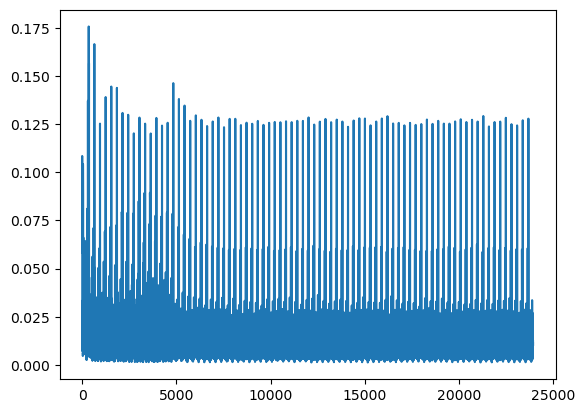

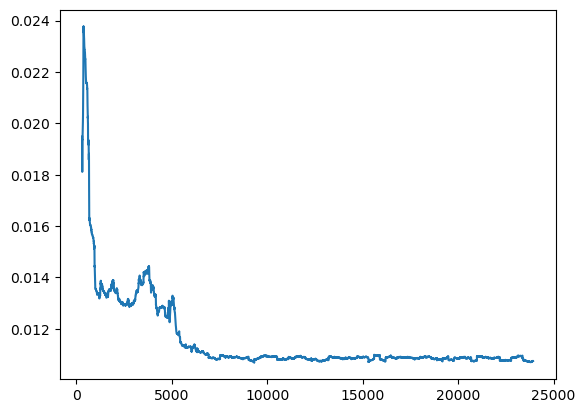

Average loss of last 299 periods: 0.010749476678345514


In [2]:
print(f'Attention: {ATTENTION} | FULL_IVS: {FULL_IVS} | LATENT_DIM: {LATENT_DIM}')

if ATTENTION:
    LSTM = AttentionLSTM(hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, latent_dim=LATENT_DIM, full_ivs=FULL_IVS)
    optimizer = optim.Adam(LSTM.parameters(), lr=LEARNING_RATE)
else:
    LSTM = LSTM(hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, latent_dim=LATENT_DIM, full_ivs=FULL_IVS)
    optimizer = optim.Adam(LSTM.parameters(), lr=LEARNING_RATE)

iv_data = getVAE_DataLoader(section='all', batch_size=1, scale=False, scaler_id=VAE.getID, filepath='data/R2_STD_IVS_DFW_SORTED.pkl')
lstm_data = getLSTM_Dataloader(section='train', vae_model=VAE, iv_dataloader=iv_data, scale=True, NNtype='DNN', batch_size=BATCH_SIZE, full_ivs=FULL_IVS, scaler_id=LSTM.getID())

loss_graph = train_LSTM(num_epochs=NUM_EPOCHS, model=LSTM, optimizer=optimizer, dataloader=lstm_data, logging_interval=20)

plt.plot(loss_graph)
plt.show()

test = pd.DataFrame(loss_graph)
test['rolling'] = test.rolling(299).mean()

plt.plot(test['rolling'])
plt.show()

print(f'Average loss of last 299 periods: {test["rolling"].iloc[-1]}')

In [3]:
LSTM.getID()

2030230

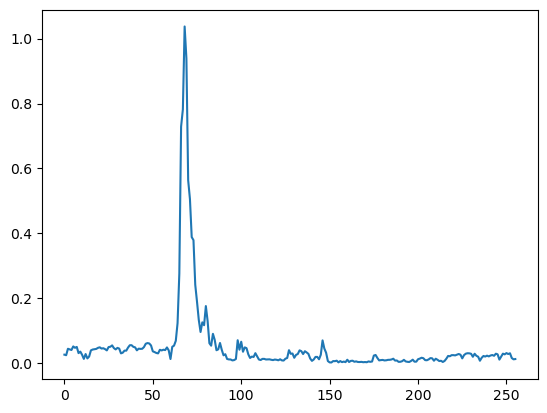

In [4]:
val_LSTM_DATA = getLSTM_Dataloader(section='valid', vae_model=VAE, iv_dataloader=iv_data, scale=True, NNtype='DNN', batch_size=2, full_ivs=FULL_IVS, scaler_id=LSTM.getID())
valid_graph = eval_LSTM(LSTM, val_LSTM_DATA, full_ivs=FULL_IVS)

plt.plot(valid_graph)
plt.show()

scores = pd.read_csv('model_scores/LSTM.csv')
entry = pd.DataFrame()
entry['LR'] = [LEARNING_RATE]
entry['BATCH_SIZE'] = BATCH_SIZE
entry['NUM_EPOCHS'] = NUM_EPOCHS
entry['LATENT_DIM'] = LATENT_DIM
entry['ATT'] = ATTENTION
entry['FULL_IVS'] = FULL_IVS
entry['VAE_ID'] = VAE.getID()
entry['NUM_LAYERS'] = NUM_LAYERS
entry['HIDDEN_SIZE'] = HIDDEN_SIZE
entry['MEAN_LOSS'] = np.array(valid_graph).mean()
entry['STD_LOSS'] = np.array(valid_graph).std()
entry['RATIO'] = np.array(valid_graph).mean() /  np.array(valid_graph).std()
entry['ID#'] = LSTM.getID()
scores = pd.concat([scores, entry], axis=0).reset_index().drop(columns=['index', 'Unnamed: 0'])
scores.to_csv('model_scores/LSTM.csv')

torch.save(LSTM.state_dict(), f'all_models/LSTM_{LSTM.getID()}.pt')

In [5]:
num_stop = 17
count = 0
for feature, target in val_LSTM_DATA:
    feature = feature[:, None, :]
    output = LSTM(feature)
    if count == num_stop:
        break
    count += 1

#target = getUnscaledData(target, 'scalers/LSTM_scaler_o.pkl')
#output = getUnscaledData(output.detach(), 'scalers/LSTM_scaler_o.pkl')
    
#target = target[0].detach().numpy()
#output = output[0].detach().numpy()

In [6]:
output[0]

tensor([0.1525, 0.7092, 0.7850, 0.1888, 0.2942, 0.7774, 0.4614, 0.8421, 0.7144,
        0.5811, 0.4421, 0.6720, 0.5574, 0.5243, 0.3372, 0.7652, 0.7102, 0.8293,
        0.6488, 0.6112], grad_fn=<SelectBackward0>)

Output


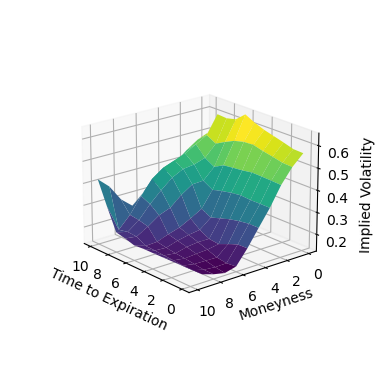

Target


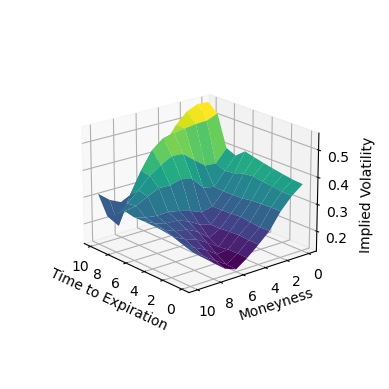

In [32]:
fig = plt.figure(40)
ax = fig.add_subplot(111, projection='3d')

date_using = pd.DataFrame(output.reshape(11, 11))
x, y = np.meshgrid(date_using.columns, date_using.index)
z = date_using.values

my_cmap = plt.get_cmap('viridis')
ax.plot_surface(y, x, z, cmap=my_cmap)
ax.view_init(20, 140) 
ax.set_xlabel('Time to Expiration', labelpad=7)
ax.set_ylabel('Moneyness', labelpad=6)
ax.set_zlabel('Implied Volatility', labelpad=8)
ax.set_box_aspect(aspect=None, zoom=0.7)
print('Output')
plt.show()

fig = plt.figure(40)
ax = fig.add_subplot(111, projection='3d')

date_using = pd.DataFrame(target.reshape(11, 11))
x, y = np.meshgrid(date_using.columns, date_using.index)
z = date_using.values

my_cmap = plt.get_cmap('viridis')
ax.plot_surface(y, x, z, cmap=my_cmap)
ax.view_init(20, 140) 
ax.set_xlabel('Time to Expiration', labelpad=7)
ax.set_ylabel('Moneyness', labelpad=6)
ax.set_zlabel('Implied Volatility', labelpad=8)
ax.set_box_aspect(aspect=None, zoom=0.7)
print('Target')
plt.show()

In [7]:
latent_means = []
latent_vars = []
for o_idx, tensor in enumerate(output):
    latent_means.append([])
    latent_vars.append([])
    for idx, item in enumerate(tensor):
        if idx % 2 == 0:
            latent_means[o_idx].append(item.item())
        else:
            latent_vars[o_idx].append(item.item())

In [8]:
latent_means

[[0.1525232195854187,
  0.7849597930908203,
  0.29415032267570496,
  0.46143287420272827,
  0.7143800258636475,
  0.4421336054801941,
  0.5573524236679077,
  0.33722907304763794,
  0.7102274298667908,
  0.6488178372383118],
 [0.15355117619037628,
  0.7703902721405029,
  0.30356526374816895,
  0.4590162932872772,
  0.704894483089447,
  0.4531046748161316,
  0.5612035989761353,
  0.34732410311698914,
  0.6995617151260376,
  0.6403897404670715]]

In [28]:
latent_means = torch.tensor(latent_means, dtype=torch.float32)
latent_vars = torch.tensor(latent_vars, dtype=torch.float32)

In [30]:
len(latent_means)

32

In [31]:
vae_out = VAE.decode(latent_means, latent_vars)

In [32]:
date_using = pd.DataFrame(vae_out[0][0].detach().numpy())
date_using

,0,1,2,3,4,5,6,7,8,9,10
0,0.368983,0.331321,0.285821,0.248432,0.214122,0.187493,0.166579,0.148457,0.138662,0.134409,0.142197
1,0.369225,0.324775,0.281045,0.241015,0.205246,0.181492,0.161263,0.146673,0.133885,0.132275,0.138943
2,0.362999,0.316325,0.270791,0.235756,0.199484,0.175151,0.154953,0.142652,0.134385,0.133244,0.139226
3,0.354302,0.306891,0.263321,0.225292,0.194633,0.168653,0.150569,0.139222,0.132574,0.134446,0.139039
4,0.346379,0.299179,0.256918,0.219456,0.188851,0.167236,0.148293,0.137839,0.133297,0.132810,0.137175
5,0.340048,0.290359,0.247570,0.216038,0.182652,0.161803,0.144444,0.134907,0.130418,0.130456,0.137729
6,0.331768,0.285380,0.246750,0.213516,0.183619,0.157513,0.148090,0.134374,0.129683,0.135673,0.139009
7,0.309966,0.265402,0.225778,0.198616,0.169870,0.150814,0.137568,0.128462,0.128123,0.134442,0.146681
8,0.289717,0.249058,0.214120,0.189162,0.163558,0.148078,0.134525,0.130670,0.130383,0.139587,0.154488
9,0.266001,0.230147,0.199583,0.176308,0.159295,0.146561,0.141089,0.141729,0.149450,0.162545,0.182632


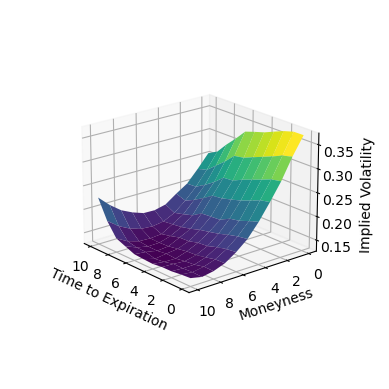

In [37]:
fig = plt.figure(40)
ax = fig.add_subplot(111, projection='3d')

date_using = pd.DataFrame(vae_out[10][0].detach().numpy())
x, y = np.meshgrid(date_using.columns, date_using.index)
z = date_using.values

my_cmap = plt.get_cmap('viridis')
ax.plot_surface(y, x, z, cmap=my_cmap)
ax.view_init(20, 140) 
ax.set_xlabel('Time to Expiration', labelpad=7)
ax.set_ylabel('Moneyness', labelpad=6)
ax.set_zlabel('Implied Volatility', labelpad=8)
ax.set_box_aspect(aspect=None, zoom=0.7)
plt.show()

In [6]:
with open('data/R2_STD_IVS_DFW.pkl', 'rb') as f:
    ivs = pickle.load(f)

In [7]:
input_data = pd.DataFrame()
for date in ivs:
    flattened = ivs[date].to_numpy().flatten()
    df = pd.DataFrame(flattened).T
    input_data = pd.concat([input_data, df], axis=0)

In [10]:
input_data.shift(-1)

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,0.395504,0.361467,0.331047,0.304242,0.281053,0.261481,0.245525,0.233185,0.224462,0.219354,...,0.246791,0.228216,0.213258,0.201917,0.194191,0.190082,0.189589,0.192712,0.199451,0.209806
0,0.467774,0.419054,0.375739,0.337829,0.305325,0.278227,0.256534,0.240247,0.229365,0.223888,...,0.209867,0.191860,0.179259,0.172063,0.170272,0.173887,0.182908,0.197334,0.217165,0.242402
0,0.372370,0.338406,0.308576,0.282882,0.261323,0.243898,0.230608,0.221453,0.216433,0.215548,...,0.252031,0.229093,0.210289,0.195620,0.185086,0.178687,0.176423,0.178294,0.184299,0.194439
0,0.291567,0.271707,0.254682,0.240492,0.229137,0.220617,0.214933,0.212083,0.212068,0.214888,...,0.272447,0.250003,0.230394,0.213620,0.199680,0.188576,0.180307,0.174873,0.172273,0.172509
0,0.355048,0.321199,0.290781,0.263793,0.240236,0.220110,0.203414,0.190148,0.180313,0.173909,...,0.223676,0.208462,0.196677,0.188324,0.183401,0.181909,0.183847,0.189216,0.198015,0.210245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.415223,0.358832,0.310069,0.268932,0.235424,0.209543,0.191289,0.180663,0.177664,0.182293,...,0.255996,0.221193,0.194017,0.174469,0.162549,0.158256,0.161591,0.172553,0.191142,0.217359
0,0.153410,0.142600,0.135831,0.133103,0.134417,0.139772,0.149169,0.162607,0.180086,0.201607,...,0.308215,0.272162,0.240151,0.212181,0.188252,0.168364,0.152518,0.140714,0.132950,0.129228
0,0.308570,0.270237,0.237921,0.211623,0.191342,0.177079,0.168833,0.166604,0.170392,0.180198,...,0.280294,0.244568,0.214860,0.191170,0.173496,0.161840,0.156201,0.156580,0.162976,0.175389
0,0.315949,0.272041,0.235254,0.205590,0.183047,0.167626,0.159326,0.158149,0.164093,0.177159,...,0.281004,0.242003,0.210124,0.185367,0.167731,0.157217,0.153825,0.157554,0.168406,0.186379
